In this notebook we want to examine the effect of T1236C, T2677G and T3435C on patient survival. 
We use data from TCGA to create Kaplan Meier curves and perform a log rank test. 

# Imports

In [28]:
import pandas as pd
import numpy as np
import os
import pickle
from Utils_MDR1 import get_cancer_muts_cur_gene, variant_info, reverse_complement, cancertype_clusters, get_rows_to_skip
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter 
from lifelines.statistics import logrank_test
from concurrent.futures import ProcessPoolExecutor
from scipy import stats



# Functions

In [74]:
''' 
Plots a Kaplan Meier survival curve and calculates the logrank test.
patients_with: a list of patients with the variant/ variants (case group).
patient_df: a dataframe with clinical information of the patients. 
''' 

def plot_KM_and_calc_logrank(patients_with: np.array, patient_df: pd.DataFrame, variant_name: str, cluster = None, balanced_dict = None) -> None:
    
    ''' Fit the kaplan meier curves '''

    # the control group - without the mutation/s
    patient_df_without_mut = patient_df[~patient_df['patient_uuid'].isin(patients_with)].copy() 
        
    #the mutated group
    if balanced_dict:
        patients_with = balanced_dict[variant_name]["with"] #take only patients in the restricted group
    patient_df_with_mut = patient_df[patient_df['patient_uuid'].isin(patients_with)].copy()

    #define parameters needed to plot the km curves - death status and time stamp
    T=patient_df_with_mut['months_alive']
    E=patient_df_with_mut['death_status']
    T1=patient_df_without_mut['months_alive']
    E1=patient_df_without_mut['death_status']
    num_patients_with = T.shape[0]
    num_patients_without = T1.shape[0]
    
    if num_patients_with != 0: 

        kmf = KaplanMeierFitter()
       # calculate the logrank_test
        results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
        pval = np.round(results.p_value,2)
        
        test_statistic = np.round(results.test_statistic,2)
        print(test_statistic)

        #plot
        ax = plt.subplot(111)
        ax = kmf.fit(T, E, label=f"Variant positive (n = {num_patients_with})").plot(ax=ax, color = "red")
        ax = kmf.fit(T1, E1, label=f"Variant negative (n = {num_patients_without})").plot(ax=ax, color = "slategrey")

        list_vars = variant_name.split("_")
        if len(list_vars) == 1: #only a single variant
            var_title = variant_name
        else:
            var_title = " , ".join(list_vars)

        title = f"{cluster}\n(p = {pval})" if cluster else f"{var_title} (p = {pval})"
        plt.title(title, size = 15)

        plt.xlabel("Time from Diagnosis [Months]", size = 15)
        plt.ylabel("Overall \nSurvival Probability [%]", size = 15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend(prop={'size': 12});


        savepath = f'../Figures/KM/km_curve_{variant_name}_{cluster}_OS.png' if cluster else f'../Figures/KM/km_curve_{variant_name}_OS.png'
        #plt.savefig(savepath, bbox_inches = "tight", dpi=500)
        plt.show()
        
    else:
        print(f"No patients in the mutated group are in the {cluster} cluster")



In [32]:
''' 
Plots a Kaplan Meier survival curve and calculates the logrank test.
patients_with: a list of patients with the variant/ variants (case group).
patient_df: a dataframe with clinical information of the patients. 
''' 

def plot_KM_and_calc_logrank_PFS(patients_with: np.array, patient_df: pd.DataFrame, variant_name: str, cluster = None, balanced_dict = None) -> None:
    
    ''' Fit the kaplan meier curves '''

    # the control group - without the mutation/s
    patient_df_without_mut = patient_df[~patient_df['patient_uuid'].isin(patients_with)].copy() 
        
    #the mutated group
    if balanced_dict:
        patients_with = balanced_dict[variant_name]["with"] #take only patients in the restricted group
    patient_df_with_mut = patient_df[patient_df['patient_uuid'].isin(patients_with)].copy()

    #define parameters needed to plot the km curves - death status and time stamp
    T=patient_df_with_mut['Progress Free Survival (Months)']
    E=patient_df_with_mut['disease_progressed']
    T1=patient_df_without_mut['Progress Free Survival (Months)']
    E1=patient_df_without_mut['disease_progressed']
    num_patients_with = T.shape[0]
    num_patients_without = T1.shape[0]
    
    if num_patients_with != 0: 

        kmf = KaplanMeierFitter()
       # calculate the logrank_test
        results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
        pval = np.round(results.p_value,2)
        
        test_statistic = np.round(results.test_statistic,2)
        print(test_statistic)

        #plot
        ax = plt.subplot(111)
        ax = kmf.fit(T, E, label=f"Variant positive (n = {num_patients_with})").plot(ax=ax, color = "red")
        ax = kmf.fit(T1, E1, label=f"Variant negative (n = {num_patients_without})").plot(ax=ax, color = "slategrey")

        list_vars = variant_name.split("_")
        if len(list_vars) == 1: #only a single variant
            var_title = variant_name
        else:
            var_title = " , ".join(list_vars)

        title = f"{cluster}\n(p = {pval})" if cluster else f"{var_title} (p = {pval})"
        plt.title(title, size = 15)

        plt.xlabel("Time from Diagnosis [Months]", size = 15)
        plt.ylabel("Progression-Free \nSurvival Probability [%]", size = 15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend(prop={'size': 12});


        savepath = f'../Figures/KM/km_curve_{variant_name}_{cluster}_PFS.png' if cluster else f'../Figures/KM/km_curve_{variant_name}_PFS.png'
        plt.savefig(savepath, bbox_inches = "tight", dpi=500)
        plt.show()
        
    else:
        print(f"No patients in the mutated group are in the {cluster} cluster")



In [66]:
# Build an index of the relevant CSV files - maps a cancer type to the relevant files
def build_file_index(root_path: str) -> dict:
    file_index = {}
    for root, dirs, files in os.walk(root_path):
        for project_file in files: #name is the cancer type
            if "maf" in project_file:
                project_name = project_file.split(".")[0]
                gene_folder = os.path.basename(root)
                path_to_folder = os.path.join(root_path, gene_folder, project_file)
                if project_name not in file_index:
                    file_index[project_name] = []
                file_index[project_name].append(path_to_folder)
    return(file_index)

In [67]:
''' Get the csv file with all TCGA mutations in this gene and cancer type and create a df with the mutations of a single patient '''
def process_csv_file(path_to_df: str, case_id: str) -> pd.DataFrame:
    num_rows_to_skip = get_rows_to_skip(path_to_df)
    temp_df = pd.read_csv(path_to_df, sep="\t", skiprows=num_rows_to_skip)
    temp_df = temp_df[temp_df["case_id"] == case_id].copy() #keep only variants of the current patient
    temp_df = temp_df[~temp_df["EXON"].isna()] #keep only variants in the exon
    return(temp_df.shape[0])


In [68]:
''' Get all the TCGA mutations of a single patient '''
def get_num_muts_single_patient(case_id: str, patient_cancer_type: str, file_index: dict) -> int:
    counter = 0
    if patient_cancer_type in file_index:
        csv_files = file_index[patient_cancer_type]
        with ProcessPoolExecutor() as executor:
            futures = []
            for csv_file in csv_files:
                futures.append(executor.submit(process_csv_file, csv_file, case_id))
            counter = sum(f.result() for f in futures)
    return(counter)


In [71]:
''' Check if the TMB is balanced between two groups using a KS test '''
def check_if_balanced(num_muts_patients: dict, people_with_variant: list, people_without_variant: list):
    
    num_muts_with = []
    num_muts_without = []
    
    for patient, num_muts in num_muts_patients.items():
        if patient in people_with_variant:
            num_muts_with.append(num_muts)
        if patient in people_without_variant:
            num_muts_without.append(num_muts)
            
    #check whether the samples of the mutated and unmutated group (the number of mutations per patient) 
    #come from the same distribution or not
    return(stats.ks_2samp(np.array(num_muts_with), np.array(num_muts_without)))
    

# Main

In [5]:
# get info of the gene
gene = 'ENSG00000085563' #MDR1/ABCB1 gene
gene_name = "ABCB1"

#get all mutations of this gene from TCGA
cancer_muts_mdr1 = get_cancer_muts_cur_gene(gene_name) #get mutations of the cancerous cohort of the current gene
num_patients = len(cancer_muts_mdr1["case_id"].unique())
num_muts = cancer_muts_mdr1.shape[0]
print(f"There are {num_patients} patients with {num_muts} mutations in this gene")


There are 3677 patients with 7559 mutations in this gene


In [6]:
#create a df with all patients' clinical info
patient_df = pd.DataFrame()

rootdir = '../Data/TCGA/'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file == 'PtntInfoTble.txt': 
            path_to_file = os.path.join(subdir, file)
            patients_info_cur_cancertype = pd.read_csv(path_to_file)
            patient_df = pd.concat([patient_df, patients_info_cur_cancertype], sort =  True)


In [7]:
# define the "death_status" and "timestamp" atributes required for the KM curves

patient_df['death_status'] = patient_df['days_to_death'] > 0 #death_status == True for patients that have an int>0 in the days_to_death column 

# the time stamp value is defined as the last time we knew the vital status of the patient. meaning it is the 
# maximum value in the columns "days to followup", "days to know alive", "days to death". 
cols = [x for x in patient_df.columns if 'days_to_followup' in x or 'days_to_know_alive' in x] + ['days_to_death']
patient_df['days_alive'] = patient_df[cols].max(axis=1)  
patient_df['months_alive'] = patient_df["days_alive"] / 12

# remove missing data
patient_df = patient_df[np.isfinite(patient_df.months_alive)] #removing people with no info on them in the relevant columns, we dont know anything about them that will help this model



## Plot overall survival curves for the three variants - Figure 6 in the main paper

### T1236C

5.22


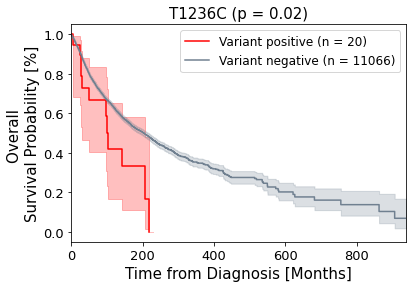

In [13]:
#variant info
cds_position = variant_info[1]["cds_position"]
change_to = variant_info[1]["change_to"]
variant_name = variant_info[1]["variant_name"]

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_1236 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()


#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_1236, patient_df, variant_name)


### T2677G

0.51


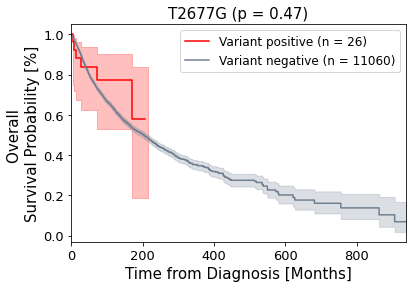

In [14]:
#variant info
cds_position = variant_info[2]["cds_position"]
change_to = variant_info[2]["change_to"]
variant_name = variant_info[2]["variant_name"]

#get list of patients with this mutation in TCGA
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_2677 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_2677, patient_df, variant_name)


### T3435C

0.05


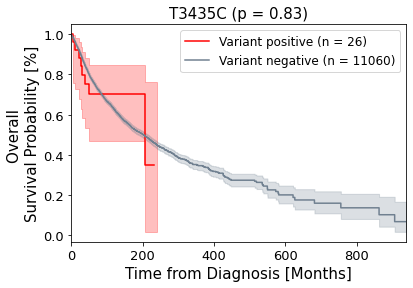

In [15]:
#variant info
cds_position = variant_info[3]["cds_position"]
change_to = variant_info[3]["change_to"]
variant_name = variant_info[3]["variant_name"]

#get list of patients with this mutation in TCGA
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_3435 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_3435, patient_df, variant_name)


## Plot overall survival curves for the haplotypes - Figure S3

### T1236C & T2677G

0.05


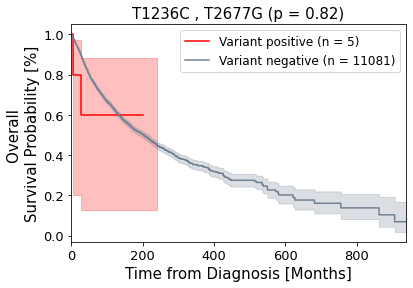

In [16]:
variant_name = "T1236C_T2677G"
patients_1236_2677 = [patient for patient in patients_with_mut_1236 if patient in patients_with_mut_2677]
plot_KM_and_calc_logrank(patients_1236_2677, patient_df, variant_name)


### T1236C & T3435C

0.03


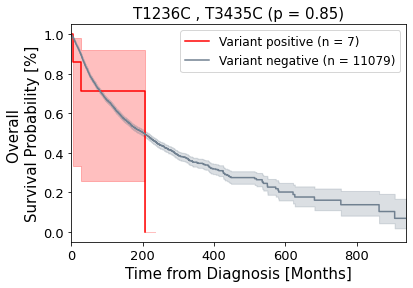

In [17]:
variant_name = "T1236C_T3435C"
patients_1236_3435 = [patient for patient in patients_with_mut_1236 if patient in patients_with_mut_3435]
plot_KM_and_calc_logrank(patients_1236_3435, patient_df, variant_name)



### T2677G & T3435C

0.08


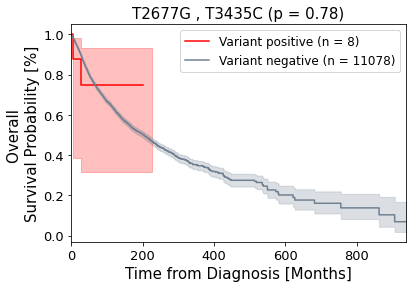

In [18]:
variant_name = "T2677G_T3435C"
patients_2677_3435 = [patient for patient in patients_with_mut_2677 if patient in patients_with_mut_3435]
plot_KM_and_calc_logrank(patients_2677_3435, patient_df, variant_name)


### T1236C & T2677G & T3435C

0.05


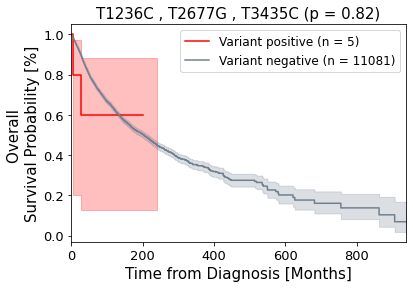

In [19]:
variant_name = "T1236C_T2677G_T3435C"
patients_1236_2677_3435 = [patient for patient in patients_2677_3435 if patient in patients_with_mut_1236]
plot_KM_and_calc_logrank(patients_1236_2677_3435, patient_df, variant_name)


In [21]:
## T1236C | T2677G | T3435C
variant_name = "any_of_three"
patients_any = np.unique(list(patients_with_mut_1236) + list(patients_with_mut_2677) + list(patients_with_mut_3435))
#plot_KM_and_calc_logrank(patients_any, patient_df, variant_name)

In [22]:
#lets save a dictionary with the patients that have the mutations or the haplotypes. It can be useful for further analyses. 

patients_dict = {
    "T1236C": patients_with_mut_1236, "T2677G": patients_with_mut_2677, "T3435C": patients_with_mut_3435,
    "T1236C_T2677G": patients_1236_2677, "T1236C_T3435C": patients_1236_3435, "T2677G_T3435C": patients_2677_3435,
    "T1236C_T2677G_T3435C": patients_1236_2677_3435, "any_of_three": patients_any
}

with open(f"../Data/mutated_patients_dict.pickle",'wb') as f:
    pickle.dump(patients_dict, f)


## Plot overall survival curves for the three variants, split patients according to cancer types - Figure S5

In [26]:
patients_dict = pd.read_pickle(f"../Data/mutated_patients_dict.pickle") #list of patients with the variants/haplotypes
cancer_types_df = pd.read_pickle("../Data/TCGA_patients_and_cancer_types_df.pickle") #patient ids mapped to their cancer type
cancer_types_df["for_cluster"] = cancer_types_df["Cancer_Type"].apply(lambda x: f"TCGA-{x}")

### T1236C

Metabolic Cancers
No patients in the mutated group are in the Metabolic Cancers cluster
Proliferative Cancers
3.63


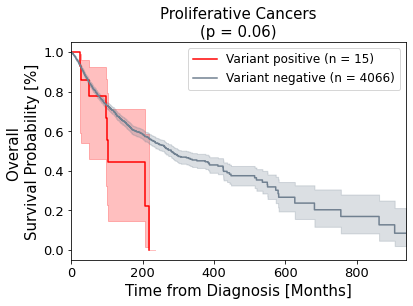

Inflammatory Cancers
11.37


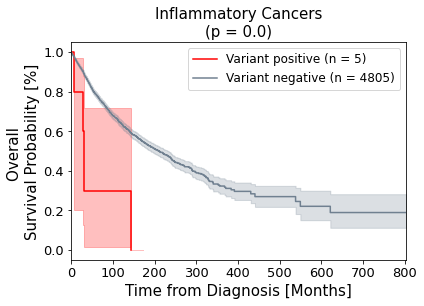

In [29]:
#variant info
mut_num = 1 #T1236C in "variant_info"
variant_name = variant_info[mut_num]["variant_name"]
patients_with_mut = patients_dict[variant_name]

for cluster in cancertype_clusters:
    
    #get a list of TCGA patients in the cluster
    patients_cluster = cancer_types_df[cancer_types_df["for_cluster"].isin(cancertype_clusters[cluster])]["case_id"].to_list() 
    #get the slice of the patients_df of the patients in the cluster
    patients_df_cluster = patient_df[patient_df["patient_uuid"].isin(patients_cluster)].copy()
    #Plot the KM curve
    print(cluster)
    plot_KM_and_calc_logrank(patients_with_mut, patients_df_cluster, variant_name, cluster)


### T2677G

Metabolic Cancers
0.23


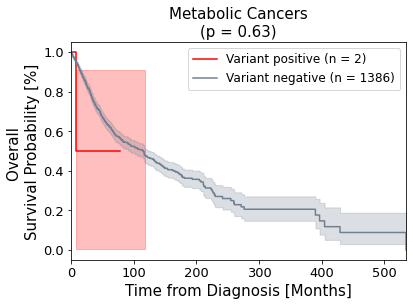

Proliferative Cancers
1.07


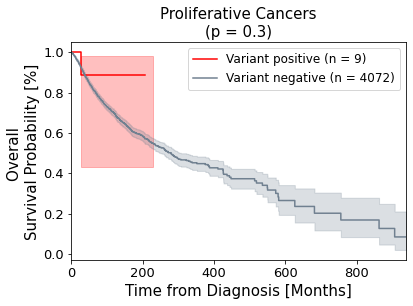

Inflammatory Cancers
0.0


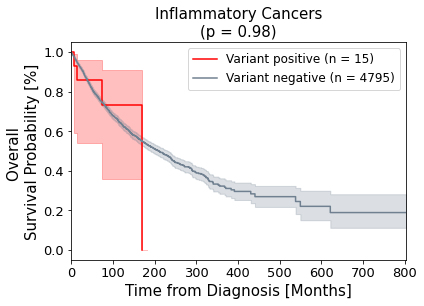

In [30]:
#variant info
mut_num = 2 #T2677G in "variant_info"
variant_name = variant_info[mut_num]["variant_name"]
patients_with_mut = patients_dict[variant_name]

for cluster in cancertype_clusters:
    
    #get a list of TCGA patients in the cluster
    patients_cluster = cancer_types_df[cancer_types_df["for_cluster"].isin(cancertype_clusters[cluster])]["case_id"].to_list() 
    #get the slice of the patients_df of the patients in the cluster
    patients_df_cluster = patient_df[patient_df["patient_uuid"].isin(patients_cluster)].copy()
    #Plot the KM curve
    print(cluster)
    plot_KM_and_calc_logrank(patients_with_mut, patients_df_cluster, variant_name, cluster)


### T3435C

Metabolic Cancers
No patients in the mutated group are in the Metabolic Cancers cluster
Proliferative Cancers
0.35


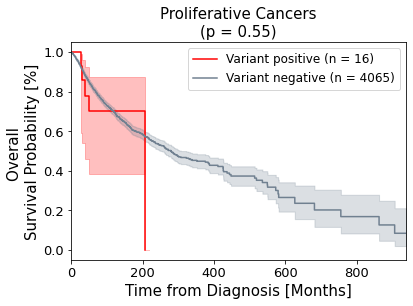

Inflammatory Cancers
0.26


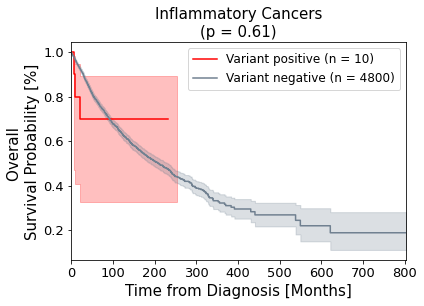

In [31]:
#variant info
mut_num = 3 #T2677G in "variant_info"
variant_name = variant_info[mut_num]["variant_name"]
patients_with_mut = patients_dict[variant_name]

for cluster in cancertype_clusters:
    
    #get a list of TCGA patients in the cluster
    patients_cluster = cancer_types_df[cancer_types_df["for_cluster"].isin(cancertype_clusters[cluster])]["case_id"].to_list() 
    #get the slice of the patients_df of the patients in the cluster
    patients_df_cluster = patient_df[patient_df["patient_uuid"].isin(patients_cluster)].copy()
    #Plot the KM curve
    print(cluster)
    plot_KM_and_calc_logrank(patients_with_mut, patients_df_cluster, variant_name, cluster)


## Plot progression free survival (PFS) curves for the three variants - Figure 6 in the main paper

**Note**: The clincal data we downloaded to power on 2018 does not have relevant data to plot a progression free survival. 
However, I found additional clinical info for the same patients in cBioPortal. So I am using it to create the PFS curves. 
Additionally, this data has the fields "Overall Survival (Months)" and "Overall Survival Status" which can be used to asses the overall survival. I checked it and the results I get are similar to the ones I get with the data I originally used.  

In [34]:
''' Get clinical data of all TCGA patients that is available on cBioPortal '''

clinical_data_cbioportal = pd.read_csv("../Data/TCGA_clinical_cbioportal/combined_study_clinical_data.tsv", sep = "\t")
clinical_data_cbioportal = clinical_data_cbioportal[~clinical_data_cbioportal["Other Patient ID"].isna()].copy() #remove patient with no id
clinical_data_cbioportal["patient_uuid"] = clinical_data_cbioportal["Other Patient ID"].apply(lambda x: x.lower())

#get the atrbutes needed for the PFS curves
clinical_data_cbioportal["disease_progressed"] = clinical_data_cbioportal["Progression Free Status"] == "1:PROGRESSION"
clinical_data_cbioportal["deceased"] = clinical_data_cbioportal["Overall Survival Status"] == "1:DECEASED"

In [35]:
# get info of the gene
gene = 'ENSG00000085563' #MDR1/ABCB1 gene
gene_name = "ABCB1"

#get all mutations of this gene from TCGA
cancer_muts_mdr1 = get_cancer_muts_cur_gene(gene_name) #get mutations of the cancerous cohort of the current gene
num_patients = len(cancer_muts_mdr1["case_id"].unique())
num_muts = cancer_muts_mdr1.shape[0]
print(f"There are {num_patients} patients with {num_muts} mutations in this gene")


There are 3677 patients with 7559 mutations in this gene


### T1236C

1.58


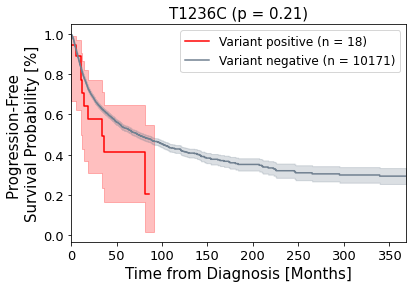

In [36]:
#variant info
cds_position = variant_info[1]["cds_position"]
change_to = variant_info[1]["change_to"]
variant_name = variant_info[1]["variant_name"]

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_1236 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank_PFS(patients_with_mut_1236, clinical_data_cbioportal, variant_name)


### T2677

4.22


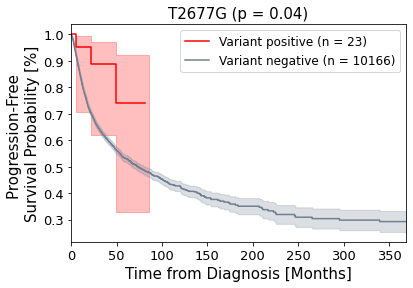

In [37]:
#variant info
cds_position = variant_info[2]["cds_position"]
change_to = variant_info[2]["change_to"]
variant_name = variant_info[2]["variant_name"]

#get list of patients with this mutation in TCGA
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_2677 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank_PFS(patients_with_mut_2677, clinical_data_cbioportal, variant_name)


### T3435C

0.04


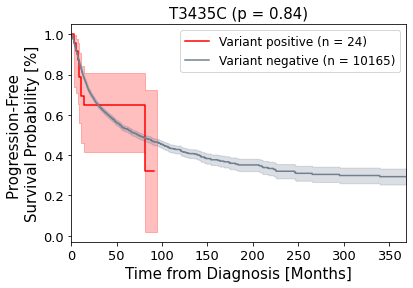

In [38]:
#variant info
cds_position = variant_info[3]["cds_position"]
change_to = variant_info[3]["change_to"]
variant_name = variant_info[3]["variant_name"]

#get list of patients with this mutation in TCGA
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_3435 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank_PFS(patients_with_mut_3435, clinical_data_cbioportal, variant_name)


## Plot progression free survival curves for the haplotypes - Figure S3

### T1236C &M T2677G

0.39


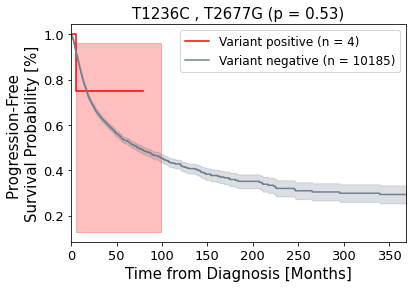

In [39]:
variant_name = "T1236C_T2677G"
patients_1236_2677 = [patient for patient in patients_with_mut_1236 if patient in patients_with_mut_2677]
plot_KM_and_calc_logrank_PFS(patients_1236_2677, clinical_data_cbioportal, variant_name)


### T1236C & T3435C

0.02


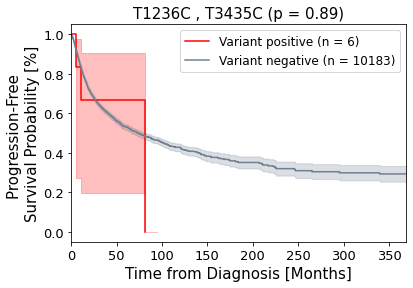

In [40]:
variant_name = "T1236C_T3435C"
patients_1236_3435 = [patient for patient in patients_with_mut_1236 if patient in patients_with_mut_3435]
plot_KM_and_calc_logrank_PFS(patients_1236_3435, clinical_data_cbioportal, variant_name)


### T2677G & T3435C

1.26


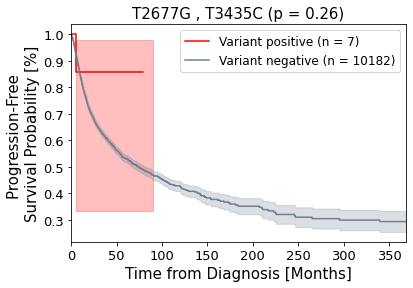

In [41]:
variant_name = "T2677G_T3435C"
patients_2677_3435 = [patient for patient in patients_with_mut_2677 if patient in patients_with_mut_3435]
plot_KM_and_calc_logrank_PFS(patients_2677_3435, clinical_data_cbioportal, variant_name)


### T1236C & T2677G & T3435C

0.39


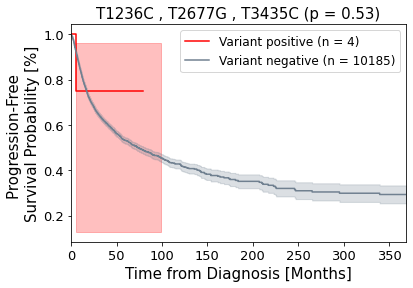

In [42]:
## T1236C & T2677G & T3435C
variant_name = "T1236C_T2677G_T3435C"
patients_1236_2677_3435 = [patient for patient in patients_2677_3435 if patient in patients_with_mut_1236]
plot_KM_and_calc_logrank_PFS(patients_1236_2677_3435, clinical_data_cbioportal, variant_name)


## Plot progression free survival curves for the three variants, split patients according to cancer types - Figure S6

In [43]:
patients_dict = pd.read_pickle(f"../Data/mutated_patients_dict.pickle")
cancer_types_df = pd.read_pickle("../Data/TCGA_patients_and_cancer_types_df.pickle")
cancer_types_df["for_cluster"] = cancer_types_df["Cancer_Type"].apply(lambda x: f"TCGA-{x}")

### T1236

Metabolic Cancers
No patients in the mutated group are in the Metabolic Cancers cluster
Proliferative Cancers
0.28


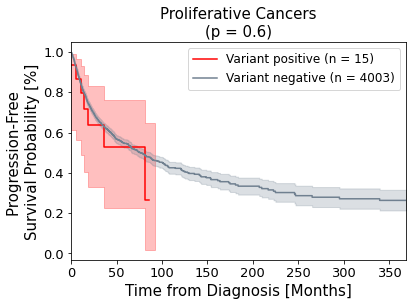

Inflammatory Cancers
6.8


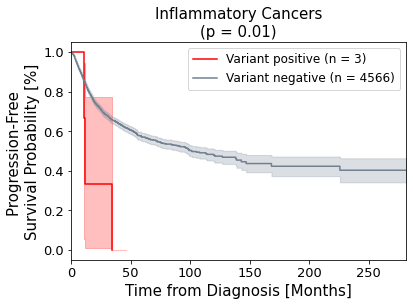

In [44]:
#variant info
mut_num = 1 #T1236C in "variant_info"
variant_name = variant_info[mut_num]["variant_name"]
patients_with_mut = patients_dict[variant_name]

for cluster in cancertype_clusters:
    
    #get a list of TCGA patients in the cluster
    patients_cluster = cancer_types_df[cancer_types_df["for_cluster"].isin(cancertype_clusters[cluster])]["case_id"].to_list() 
    #get the slice of the patients_df of the patients in the cluster
    patients_df_cluster = clinical_data_cbioportal[clinical_data_cbioportal["patient_uuid"].isin(patients_cluster)].copy()
    #Plot the KM curve
    print(cluster)
    plot_KM_and_calc_logrank_PFS(patients_with_mut, patients_df_cluster, variant_name, cluster)


### T2677G

Metabolic Cancers
0.19


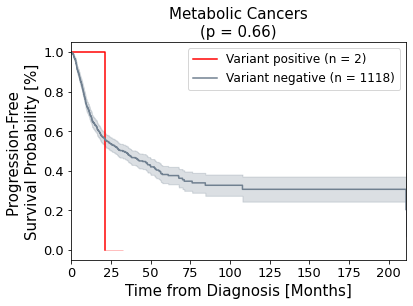

Proliferative Cancers
2.28


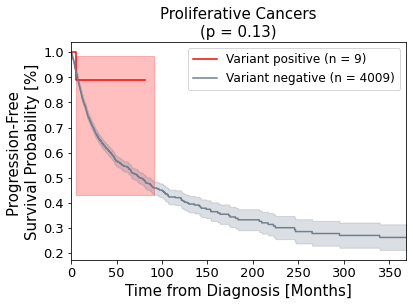

Inflammatory Cancers
2.4


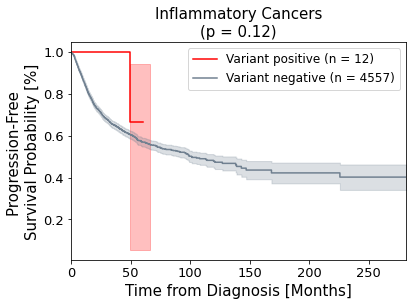

In [45]:
#variant info
mut_num = 2 #T2677G in "variant_info"
variant_name = variant_info[mut_num]["variant_name"]
patients_with_mut = patients_dict[variant_name]

for cluster in cancertype_clusters:
    
    #get a list of TCGA patients in the cluster
    patients_cluster = cancer_types_df[cancer_types_df["for_cluster"].isin(cancertype_clusters[cluster])]["case_id"].to_list() 
    #get the slice of the patients_df of the patients in the cluster
    patients_df_cluster = clinical_data_cbioportal[clinical_data_cbioportal["patient_uuid"].isin(patients_cluster)].copy()
    #Plot the KM curve
    print(cluster)
    plot_KM_and_calc_logrank_PFS(patients_with_mut, patients_df_cluster, variant_name, cluster)


### T3435C

Metabolic Cancers
No patients in the mutated group are in the Metabolic Cancers cluster
Proliferative Cancers
0.62


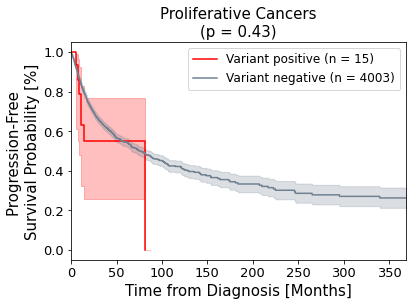

Inflammatory Cancers
0.17


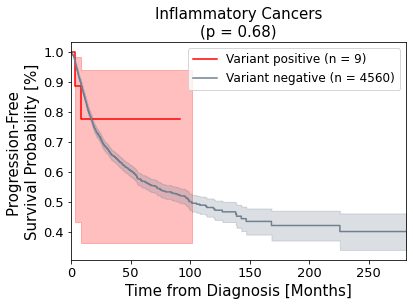

In [46]:
#variant info
mut_num = 3 #T2677G in "variant_info"
variant_name = variant_info[mut_num]["variant_name"]
patients_with_mut = patients_dict[variant_name]

for cluster in cancertype_clusters:
    
    #get a list of TCGA patients in the cluster
    patients_cluster = cancer_types_df[cancer_types_df["for_cluster"].isin(cancertype_clusters[cluster])]["case_id"].to_list() 
    #get the slice of the patients_df of the patients in the cluster
    patients_df_cluster = clinical_data_cbioportal[clinical_data_cbioportal["patient_uuid"].isin(patients_cluster)].copy()
    #Plot the KM curve
    print(cluster)
    plot_KM_and_calc_logrank_PFS(patients_with_mut, patients_df_cluster, variant_name, cluster)


## Plot overall survival curves for variants highly correlated with T1236C - Figure S4
To strengthen the hypothesis that T1236C *causes* the effect on survivability, we check the effect of mutations correlated to it on survivability. 

In [50]:
'''get the list of all mutations that patients with T1236C have. These are sorted by number of occurences. '''
#for example: mut1 = 19 means that 19 out of 20 T1236C positive patients also have mut1. 

shared_muts = pd.read_pickle(f"../Data/muts_correlated_with_T1236C.pickle") #created in "get_T1236C_correlated_mutations.ipynb
print(f"Correlated mutations:\n\n{shared_muts.head(n = 10)}")


Correlated mutations:

ENSG00000184956:chr11:1016789:1016789:T:A    19
ENSG00000184956:chr11:1016779:1016779:G:A    19
ENSG00000184956:chr11:1016800:1016800:G:A    17
ENSG00000184956:chr11:1016802:1016802:T:A    16
ENSG00000184956:chr11:1016842:1016842:T:G    15
ENSG00000184956:chr11:1016810:1016810:G:T    14
ENSG00000184956:chr11:1016818:1016818:A:G    14
ENSG00000184956:chr11:1016954:1016954:G:T    14
ENSG00000184956:chr11:1017898:1017898:T:G    13
ENSG00000184956:chr11:1016906:1016906:G:T    13
Name: mut_id, dtype: int64


In [51]:
''' get only the highly correlated ones - mutations that over 75% of T1236C positive patients have ''' 

highly_correlated_muts = shared_muts > 15
highly_correlated_muts = highly_correlated_muts[highly_correlated_muts].index.to_list()
print(f"There are {len(highly_correlated_muts)} mutations that are present in more than 75% of T1236C positive patients:")
print(highly_correlated_muts)


There are 4 mutations that are present in more than 75% of T1236C positive patients:
['ENSG00000184956:chr11:1016789:1016789:T:A', 'ENSG00000184956:chr11:1016779:1016779:G:A', 'ENSG00000184956:chr11:1016800:1016800:G:A', 'ENSG00000184956:chr11:1016802:1016802:T:A']


In [ ]:
''' notice that all the correlated mutations are in MUC6, a gene that has many mutations on TCGA ''' 

gene = 'ENSG00000184956' #MDR1/ABCB1 gene
gene_name = "MUC6"

#get all mutations of this gene from TCGA
cancer_muts_cur_gene = get_cancer_muts_cur_gene(gene_name) #get mutations of the cancerous cohort of the current gene


7.86


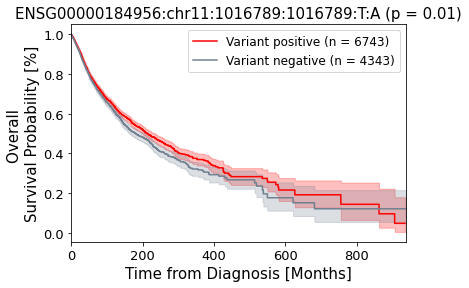

7.18


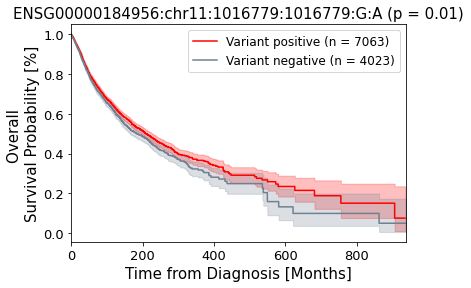

14.37


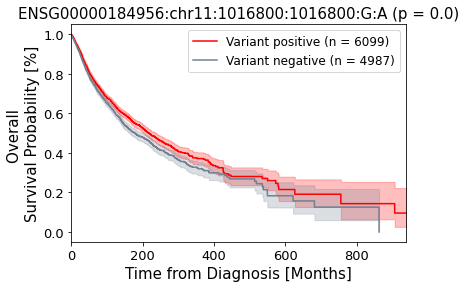

7.09


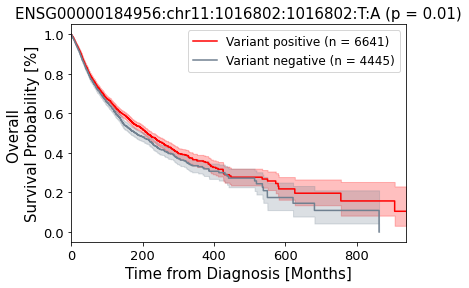

In [53]:
''' for each mutation, plot the KM curve and calculate log-rank ''' 

for mut_id in highly_correlated_muts:

    #variant info
    _, _, start_pos, _, _, alt = mut_id.split(":")

    #get list of patients with this mutation in TCGA'
    cur_position = cancer_muts_cur_gene['Start_Position'] == int(start_pos)
    cur_alt = cancer_muts_cur_gene["Tumor_Seq_Allele2"] == alt
    patients_with_this_mut = cancer_muts_cur_gene[cur_position & cur_alt]["case_id"].unique()

    #Plot the KM curve
    plot_KM_and_calc_logrank(patients_with_this_mut, patient_df, mut_id)

    plt.show()
    


In [54]:
''' Lets also check specifically for MDR1 mutations correlated with T1236C '''

indices_mdr1_muts = [i for i,name in enumerate(shared_muts.index) if "ENSG00000085563" in name] #get the rank of mutations in MDR1
highest_correlated_mdr1_mut = shared_muts[indices_mdr1_muts][:1]
mut_id = highest_correlated_mdr1_mut[:1].index[0]
num_appearances = highest_correlated_mdr1_mut[:1].values[0]
print(f"The most highly correlated MDR1 mutation is {mut_id}.\nIt appears in {num_appearances} T1236C positive patients")


The most highly correlated MDR1 mutation is ENSG00000085563:chr7:87549827:87549827:A:G.
It appears in 7 T1236C positive patients


0.24


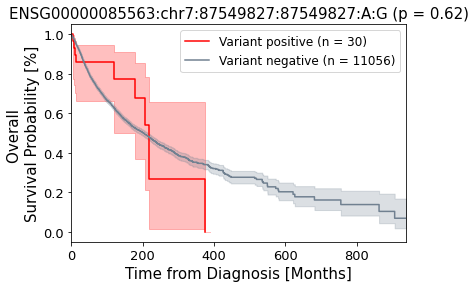

In [55]:
#variant info
_, _, start_pos, _, _, alt = mut_id.split(":")

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['Start_Position'] == int(start_pos)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"] == alt
patients_with_this_mut = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_this_mut, patient_df, mut_id)
plt.show()


We can see that the mutations that are correlated with T1236C (probably because they are very common) 
are actually correlated with *better* prognosis, unlike T1236C.  
They are all in the MUC6 gene, unknown to be related to MDR1 regulation. 
The mutations that is most highly correlated with T1236C on the MDR1 gene is "ENSG00000085563:chr7:87549827:87549827:A:G" and it is not correlated with patient survivability. 

## Control for the number of variants (TMB)
make sure that the patients with T1236C, T2677G and T3435C have on average the same amount of mutations as other TCGA patients

### Count the amount of mutations for each patient in TCGA



In [ ]:
''' our files are originized like this: TCGA/gene_name/cancer_type in the file system. We have many genes 
#and the process of opening all files takes a long time. We save time by creating a file index, this way we can 
#open only the ones we currenly need '''

root_path = "../Data/TCGA/AllGenes/"
file_index = build_file_index(root_path)

#save the file index
with open(f"../Data/paths_to_cancer_type.pickle",'wb') as f:
    pickle.dump(file_index, f)


In [ ]:
file_index = pd.read_pickle(f"../Data/paths_to_cancer_type.pickle")

In [ ]:
''' create a dictionary where the keys are patient case_ids and the values are there total number of mutations in 
all genes in the exons '''

list_patients = list(patient_df["patient_uuid"].unique())
patients_and_types = pd.read_pickle("../Data/TCGA_patients_and_cancer_types_df.pickle") #get a dict[patient] -> cancer tpye

num_muts_per_patient = {}
for patient in list_patients:
    try:
        if patient not in num_muts_per_patient.keys():
            patient_cancer_type = patients_and_types[patients_and_types["case_id"] == patient]["Cancer_Type"].values[0]
            # Call the function with the optimized code
            num_muts = get_num_muts_single_patient(patient, patient_cancer_type, file_index)
            num_muts_per_patient[patient] = num_muts
    except:
        pass

with open(f"../Data/num_muts_per_patient_exons.pickle",'wb') as f:
    pickle.dump(num_muts_per_patient, f)


### Create groups with balanced TMB

In [62]:
num_muts_patients = pd.read_pickle(f"../Data/num_muts_per_patient_exons.pickle")

In [64]:
patients_with_mdr1_muts = pd.read_pickle(f"../Data/mutated_patients_dict.pickle")
patients_T1236C = patients_with_mdr1_muts["T1236C"]
patients_T2677G = patients_with_mdr1_muts["T2677G"]
patients_T3435C = patients_with_mdr1_muts["T3435C"]

patients_T1236C_restricted = [patient for patient in patients_with_mdr1_muts["T1236C"] if num_muts_patients[patient]< 1000000]
patients_T2677G_restricted = [patient for patient in patients_with_mdr1_muts["T2677G"] if num_muts_patients[patient]< 4000]
patients_T3435C_restricted = [patient for patient in patients_with_mdr1_muts["T3435C"] if num_muts_patients[patient]< 2000]
#Note: these numbers were gathered for each group after trial and error


In [70]:
''' Check whether the mutational burden is balanced in the mutated and unmutated groups '''

'''T1236C '''
patients_witout_T1236C = [patient for patient in num_muts_patients.keys() if patient not in patients_T1236C]
res = check_if_balanced(num_muts_patients, patients_T1236C_restricted, patients_witout_T1236C)
print(f"For variant T1236C the result of the KS test is:\n{res}")

'''T2677G '''
patients_witout_T2677G = [patient for patient in num_muts_patients.keys() if patient not in patients_T2677G]
res = check_if_balanced(num_muts_patients, patients_T2677G_restricted, patients_witout_T2677G)
print(f"For variant T2677G the result of the KS test is:\n{res}")

'''T3435C '''
patients_witout_T3435C = [patient for patient in num_muts_patients.keys() if patient not in patients_T3435C]
res = check_if_balanced(num_muts_patients, patients_T3435C_restricted, patients_witout_T3435C)
print(f"For variant T3435C the result of the KS test is:\n{res}")

For variant T1236C the result of the KS test is:
Ks_2sampResult(statistic=0.2594356175065795, pvalue=0.11408104923225651)
For variant T2677G the result of the KS test is:
Ks_2sampResult(statistic=0.27421529423239105, pvalue=0.12944442171828616)
For variant T3435C the result of the KS test is:
Ks_2sampResult(statistic=0.328738472208676, pvalue=0.23215070174041263)


In [72]:
''' Save a dictionary with the patients in the balanced dataset '''
balanced_groups = {}
balanced_groups["T1236C"] = {}
balanced_groups["T1236C"]["with"] = patients_T1236C_restricted
balanced_groups["T1236C"]["without"] = patients_witout_T1236C
balanced_groups["T2677G"] = {}
balanced_groups["T2677G"]["with"] = patients_T2677G_restricted
balanced_groups["T2677G"]["without"] = patients_witout_T2677G
balanced_groups["T3435C"] = {}
balanced_groups["T3435C"]["with"] = patients_T3435C_restricted
balanced_groups["T3435C"]["without"] = patients_witout_T3435C

with open("../Data/balanced_groups_TCGA.pickle", 'wb') as handle:
    pickle.dump(balanced_groups, handle)


### Finally, check the balanced curves (data not shown in paper)

In [ ]:
''' T1236C '''

#variant info
cds_position = variant_info[1]["cds_position"]
change_to = variant_info[1]["change_to"]
variant_name = variant_info[1]["variant_name"]

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_1236 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()


#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_1236, patient_df, variant_name, balanced_groups)


In [ ]:
''' T2677G '''

#variant info
cds_position = variant_info[2]["cds_position"]
change_to = variant_info[2]["change_to"]
variant_name = variant_info[2]["variant_name"]

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_2677 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()


#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_2677, patient_df, variant_name, balanced_groups)


In [ ]:
''' T3435C '''

#variant info
cds_position = variant_info[3]["cds_position"]
change_to = variant_info[3]["change_to"]
variant_name = variant_info[3]["variant_name"]

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_3435 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()


#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_3435, patient_df, variant_name, balanced_groups)
